# Air Quality Index (AQI) Prediction

This notebook demonstrates how to build a machine learning model to predict Air Quality Index using the AQI.csv dataset. We'll use seaborn for all visualizations as requested.

## 1. Import Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# For machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Set seaborn style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

## 2. Load and Explore the Dataset

In [2]:
# Load the dataset
df = pd.read_csv('AQI.csv')

# Display the first few rows
print("Dataset Shape:", df.shape)
df.head()

Dataset Shape: (3077, 11)


,country,state,city,station,last_update,latitude,longitude,pollutant_id,pollutant_min,pollutant_max,pollutant_avg
0,India,Andhra_Pradesh,Vijayawada,"Rajiv Nagar, Vijayawada - APPCB",19-05-2025 10:00:00,16.554731,80.649110,SO2,20.0,23.0,21.0
1,India,Andhra_Pradesh,Vijayawada,"Rajiv Nagar, Vijayawada - APPCB",19-05-2025 10:00:00,16.554731,80.649110,OZONE,17.0,35.0,22.0
2,India,Andhra_Pradesh,Visakhapatnam,"GVM Corporation, Visakhapatnam - APPCB",19-05-2025 10:00:00,17.720000,83.300000,PM10,23.0,66.0,36.0
3,India,Arunachal_Pradesh,Naharlagun,"Naharlagun, Naharlagun - APSPCB",19-05-2025 10:00:00,27.103358,93.679645,NO2,4.0,5.0,5.0
4,India,Arunachal_Pradesh,Naharlagun,"Naharlagun, Naharlagun - APSPCB",19-05-2025 10:00:00,27.103358,93.679645,CO,10.0,19.0,12.0


In [3]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values[missing_values > 0])

Missing Values:
pollutant_min    299
pollutant_max    299
pollutant_avg    299
dtype: int64


In [4]:
# Get basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3077 entries, 0 to 3076
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country        3077 non-null   object 
 1   state          3077 non-null   object 
 2   city           3077 non-null   object 
 3   station        3077 non-null   object 
 4   last_update    3077 non-null   object 
 5   latitude       3077 non-null   float64
 6   longitude      3077 non-null   float64
 7   pollutant_id   3077 non-null   object 
 8   pollutant_min  2778 non-null   float64
 9   pollutant_max  2778 non-null   float64
 10  pollutant_avg  2778 non-null   float64
dtypes: float64(5), object(6)
memory usage: 264.6+ KB


In [5]:
# Statistical summary of numerical columns
df.describe()

,latitude,longitude,pollutant_min,pollutant_max,pollutant_avg
count,3077.000000,3077.000000,2778.000000,2778.000000,2778.000000
mean,22.250067,78.682006,21.670986,59.251620,33.933765
std,5.519664,4.854371,25.535470,65.896529,36.125555
min,8.514909,70.909168,1.000000,1.000000,1.000000
25%,19.036458,75.521300,5.000000,15.000000,9.000000
50%,23.023389,77.508730,13.000000,40.000000,23.000000
75%,26.833997,80.723178,29.000000,79.000000,45.000000
max,34.066206,94.636574,303.000000,500.000000,336.000000


## 3. Data Preprocessing

### 3.1 Handling Missing Values with KNN Imputation

For this analysis, we'll use KNN (K-Nearest Neighbors) imputation to handle missing values in our dataset. KNN imputation works by finding the k most similar samples to the one with missing values and using their values to fill in the gaps.

**Advantages of KNN Imputation:**
- Preserves the relationship between features
- More accurate than simple mean/median imputation for many datasets
- Takes into account the similarity between data points
- Works well when missing data has a pattern related to other features

We'll use `KNNImputer` from scikit-learn with n_neighbors=5, meaning it will consider the 5 most similar data points when imputing missing values.

In [6]:
# Demonstrate KNN imputation on a small subset of numerical data
# First, let's create a small dataset with some missing values
numerical_sample = df[['latitude', 'longitude', 'pollutant_min', 'pollutant_max', 'pollutant_avg']].sample(10)
numerical_sample.iloc[0, 2] = np.nan  # Set one value to NaN
numerical_sample.iloc[3, 4] = np.nan  # Set another value to NaN

print("Original data with missing values:")
print(numerical_sample)

# Apply KNN imputation
imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(numerical_sample)
imputed_df = pd.DataFrame(imputed_data, columns=numerical_sample.columns, index=numerical_sample.index)

print("\nData after KNN imputation:")
print(imputed_df)

# Highlight the imputed values
missing_mask = numerical_sample.isna()
for i, row in missing_mask.iterrows():
    for col in missing_mask.columns:
        if row[col]:
            print(f"\nImputed value for {col} at index {i}:")
            print(f"Original: NaN")
            print(f"Imputed: {imputed_df.loc[i, col]:.2f}")

Original data with missing values:
       latitude  longitude  pollutant_min  pollutant_max  pollutant_avg
2090  19.296481  72.840923            NaN            3.0            2.0
442   24.041198  74.780702           11.0           41.0           22.0
1111  11.679111  78.125052           16.0           17.0           16.0
1366  28.591825  77.227307           66.0          179.0            NaN
2831  31.620000  74.876512            2.0          104.0           27.0
1149  28.964949  77.278761           24.0           52.0           37.0
2878  23.555190  74.440010            4.0          139.0          108.0
1830  29.212411  78.961175            NaN            NaN            NaN
945   21.144720  79.107595           65.0           75.0           71.0
2653  13.940000  75.555917           14.0          167.0           37.0

Data after KNN imputation:
       latitude  longitude  pollutant_min  pollutant_max  pollutant_avg
2090  19.296481  72.840923           23.6            3.0            2.0
4

### 3.2 Comparing KNN Imputation with Simple Imputation Methods

In [7]:
# Let's compare KNN imputation with mean and median imputation
# Create a larger sample with more missing values for comparison
larger_sample = df[['latitude', 'longitude', 'pollutant_min', 'pollutant_max', 'pollutant_avg']].sample(100)

# Create a copy and introduce missing values (about 10%)
sample_with_missing = larger_sample.copy()
np.random.seed(42)  # For reproducibility
mask = np.random.random(sample_with_missing.shape) < 0.1
sample_with_missing[mask] = np.nan

# Store original values before making them NaN for later comparison
original_values = larger_sample.copy()
missing_positions = np.where(mask)

# Apply different imputation methods
# 1. KNN Imputation
knn_imputer = KNNImputer(n_neighbors=5)
knn_imputed = pd.DataFrame(
    knn_imputer.fit_transform(sample_with_missing),
    columns=sample_with_missing.columns,
    index=sample_with_missing.index
)

# 2. Mean Imputation
mean_imputer = SimpleImputer(strategy='mean')
mean_imputed = pd.DataFrame(
    mean_imputer.fit_transform(sample_with_missing),
    columns=sample_with_missing.columns,
    index=sample_with_missing.index
)

# 3. Median Imputation
median_imputer = SimpleImputer(strategy='median')
median_imputed = pd.DataFrame(
    median_imputer.fit_transform(sample_with_missing),
    columns=sample_with_missing.columns,
    index=sample_with_missing.index
)

# Calculate error metrics for each method
def calculate_imputation_error(imputed_df, original_df, missing_pos):
    rows, cols = missing_pos
    original_values = [original_df.iloc[r, c] for r, c in zip(rows, cols)]
    imputed_values = [imputed_df.iloc[r, c] for r, c in zip(rows, cols)]
    
    # Calculate Mean Absolute Error
    mae = np.mean(np.abs(np.array(original_values) - np.array(imputed_values)))
    
    # Calculate Root Mean Squared Error
    rmse = np.sqrt(np.mean((np.array(original_values) - np.array(imputed_values))**2))
    
    return mae, rmse

In [8]:
# Convert last_update to datetime
df['last_update'] = pd.to_datetime(df['last_update'], format='%d-%m-%Y %H:%M:%S')

# Extract date features
df['year'] = df['last_update'].dt.year
df['month'] = df['last_update'].dt.month
df['day'] = df['last_update'].dt.day
df['hour'] = df['last_update'].dt.hour

# Display the updated dataframe
df.head()

,country,state,city,station,last_update,latitude,longitude,pollutant_id,pollutant_min,pollutant_max,pollutant_avg,year,month,day,hour
0,India,Andhra_Pradesh,Vijayawada,"Rajiv Nagar, Vijayawada - APPCB",2025-05-19 10:00:00,16.554731,80.649110,SO2,20.0,23.0,21.0,2025,5,19,10
1,India,Andhra_Pradesh,Vijayawada,"Rajiv Nagar, Vijayawada - APPCB",2025-05-19 10:00:00,16.554731,80.649110,OZONE,17.0,35.0,22.0,2025,5,19,10
2,India,Andhra_Pradesh,Visakhapatnam,"GVM Corporation, Visakhapatnam - APPCB",2025-05-19 10:00:00,17.720000,83.300000,PM10,23.0,66.0,36.0,2025,5,19,10
3,India,Arunachal_Pradesh,Naharlagun,"Naharlagun, Naharlagun - APSPCB",2025-05-19 10:00:00,27.103358,93.679645,NO2,4.0,5.0,5.0,2025,5,19,10
4,India,Arunachal_Pradesh,Naharlagun,"Naharlagun, Naharlagun - APSPCB",2025-05-19 10:00:00,27.103358,93.679645,CO,10.0,19.0,12.0,2025,5,19,10


## 4. Data Visualization with Seaborn

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19336\2199391745.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='pollutant_id', data=df, palette='viridis')


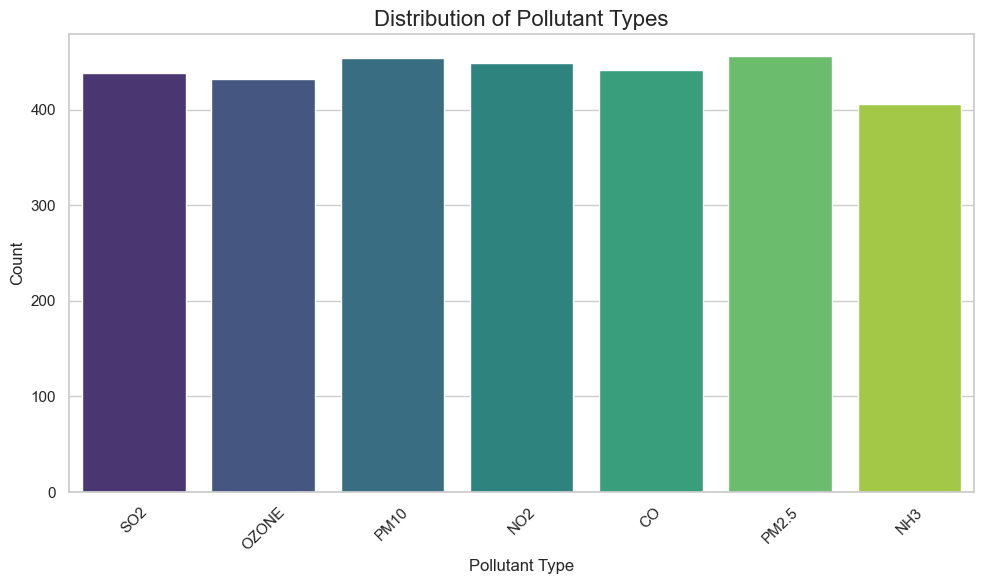

In [9]:
# Count of pollutant types
plt.figure(figsize=(10, 6))
sns.countplot(x='pollutant_id', data=df, palette='viridis')
plt.title('Distribution of Pollutant Types', fontsize=16)
plt.xlabel('Pollutant Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19336\2943660538.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='pollutant_id', y='pollutant_avg', data=df, palette='Set3')


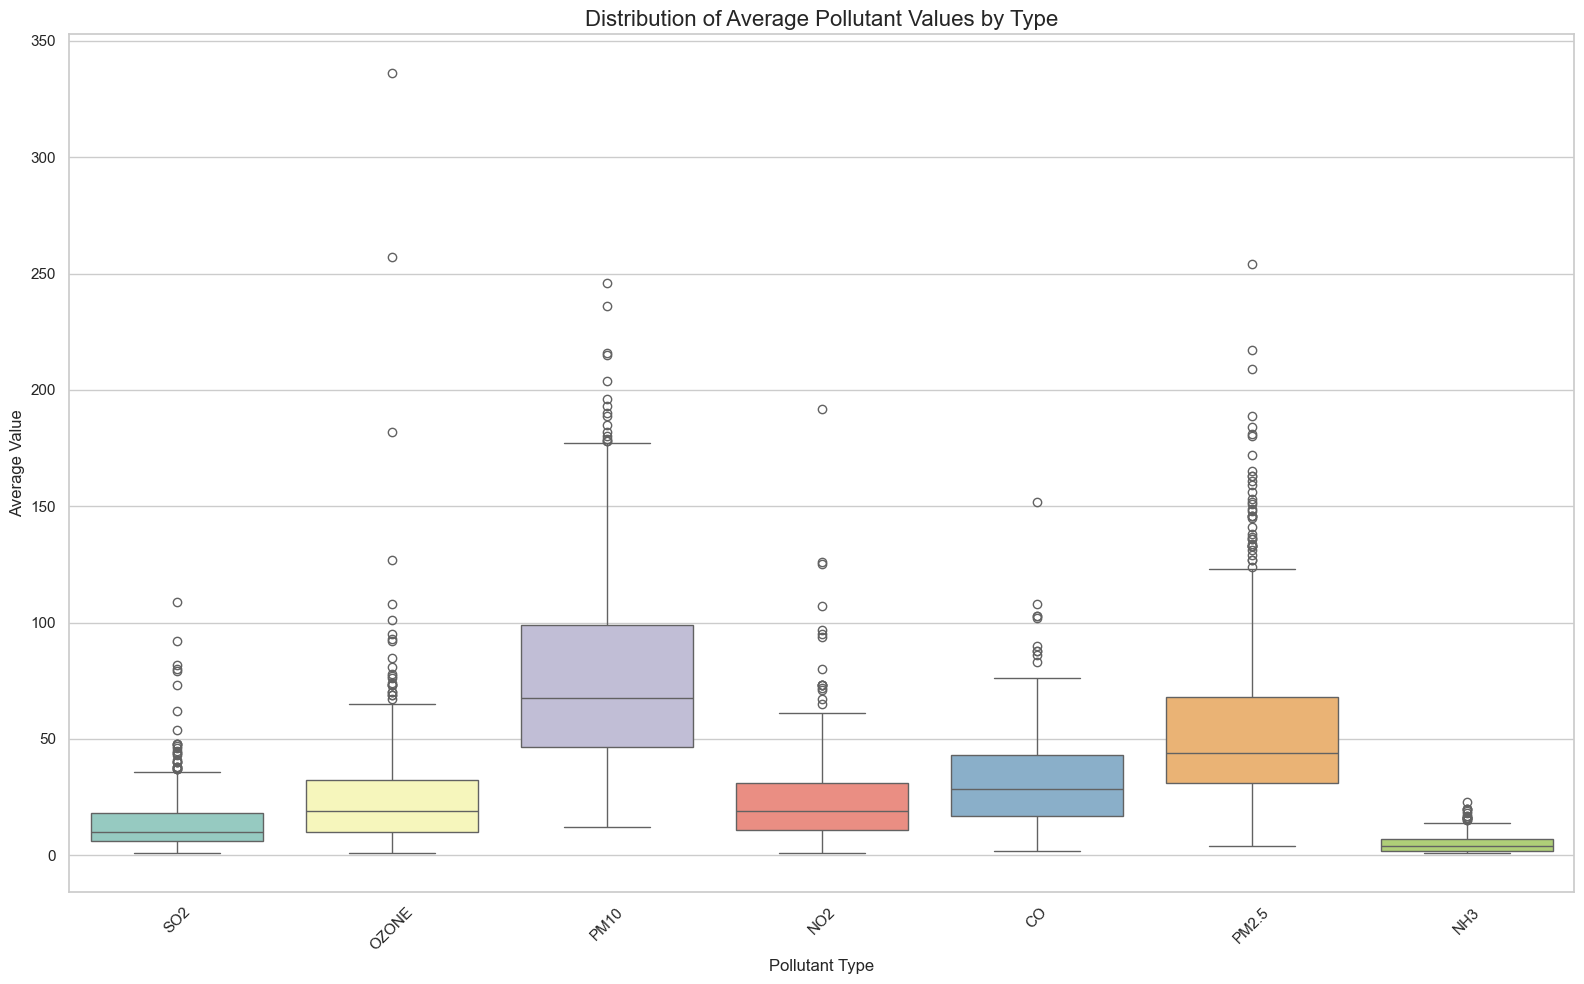

In [10]:
# Distribution of pollutant averages
plt.figure(figsize=(16, 10))
sns.boxplot(x='pollutant_id', y='pollutant_avg', data=df, palette='Set3')
plt.title('Distribution of Average Pollutant Values by Type', fontsize=16)
plt.xlabel('Pollutant Type', fontsize=12)
plt.ylabel('Average Value', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19336\2297881169.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pollutant_avg', y='city', data=city_pollution, palette='rocket')


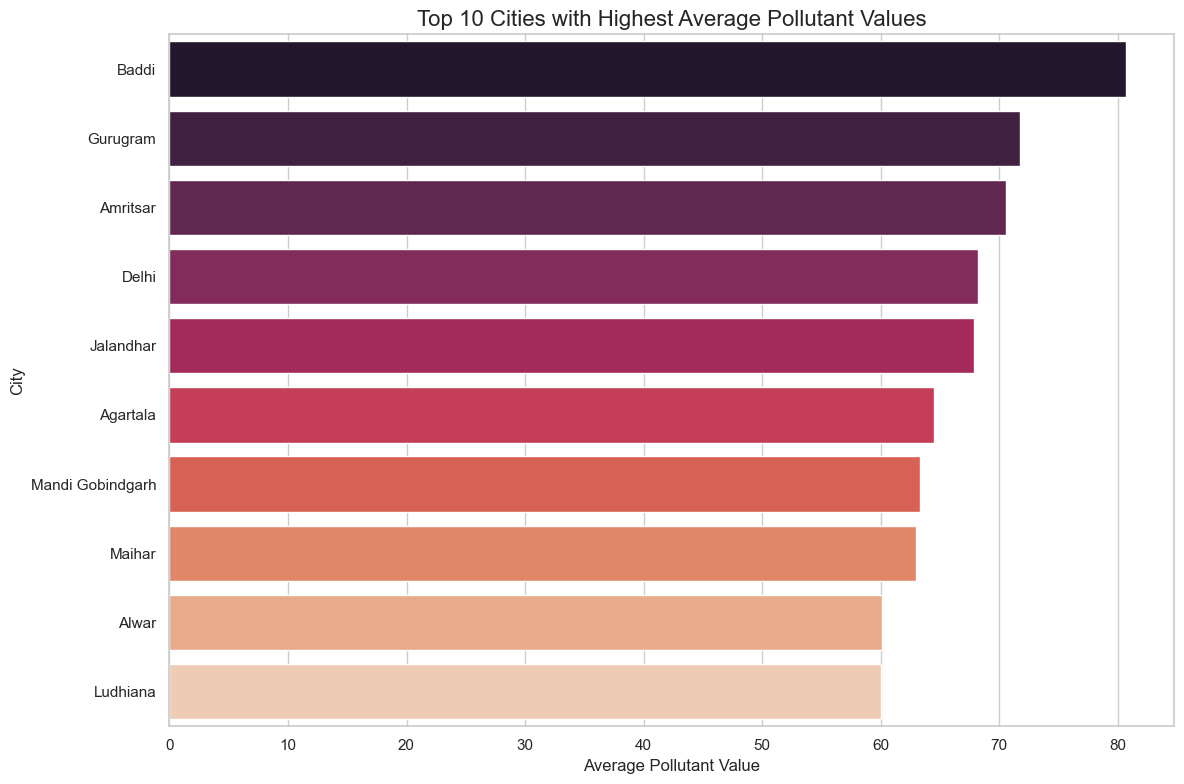

In [11]:
# Top 10 cities with highest average pollutant values
city_pollution = df.groupby('city')['pollutant_avg'].mean().sort_values(ascending=False).head(10).reset_index()

plt.figure(figsize=(12, 8))
sns.barplot(x='pollutant_avg', y='city', data=city_pollution, palette='rocket')
plt.title('Top 10 Cities with Highest Average Pollutant Values', fontsize=16)
plt.xlabel('Average Pollutant Value', fontsize=12)
plt.ylabel('City', fontsize=12)
plt.tight_layout()
plt.show()

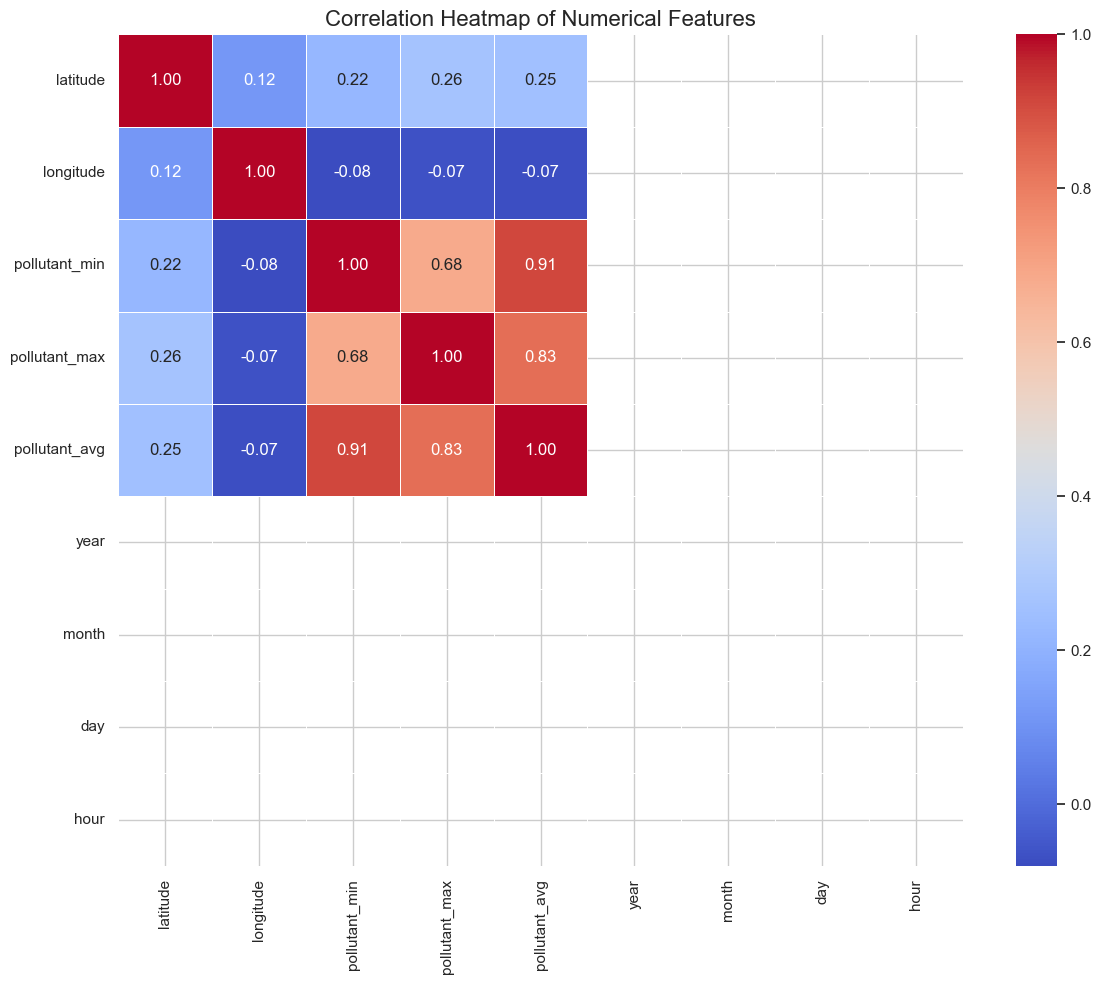

In [12]:
# Heatmap of correlation between numerical features
numerical_df = df[['latitude', 'longitude', 'pollutant_min', 'pollutant_max', 'pollutant_avg', 'year', 'month', 'day', 'hour']]
correlation = numerical_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19336\2731777073.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y='pollutant_avg', data=df, palette='YlOrRd')


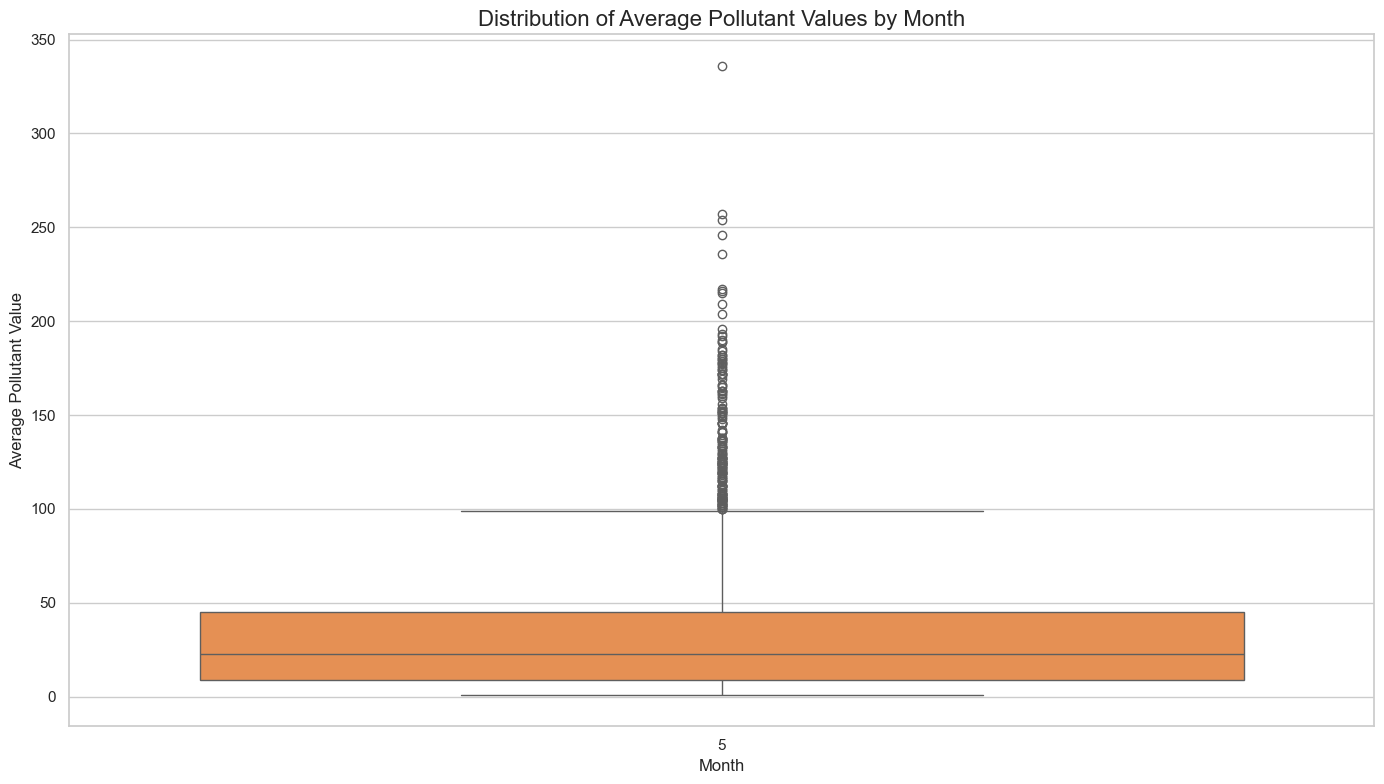

In [13]:
# Distribution of pollutant averages by month
plt.figure(figsize=(14, 8))
sns.boxplot(x='month', y='pollutant_avg', data=df, palette='YlOrRd')
plt.title('Distribution of Average Pollutant Values by Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Pollutant Value', fontsize=12)
plt.tight_layout()
plt.show()

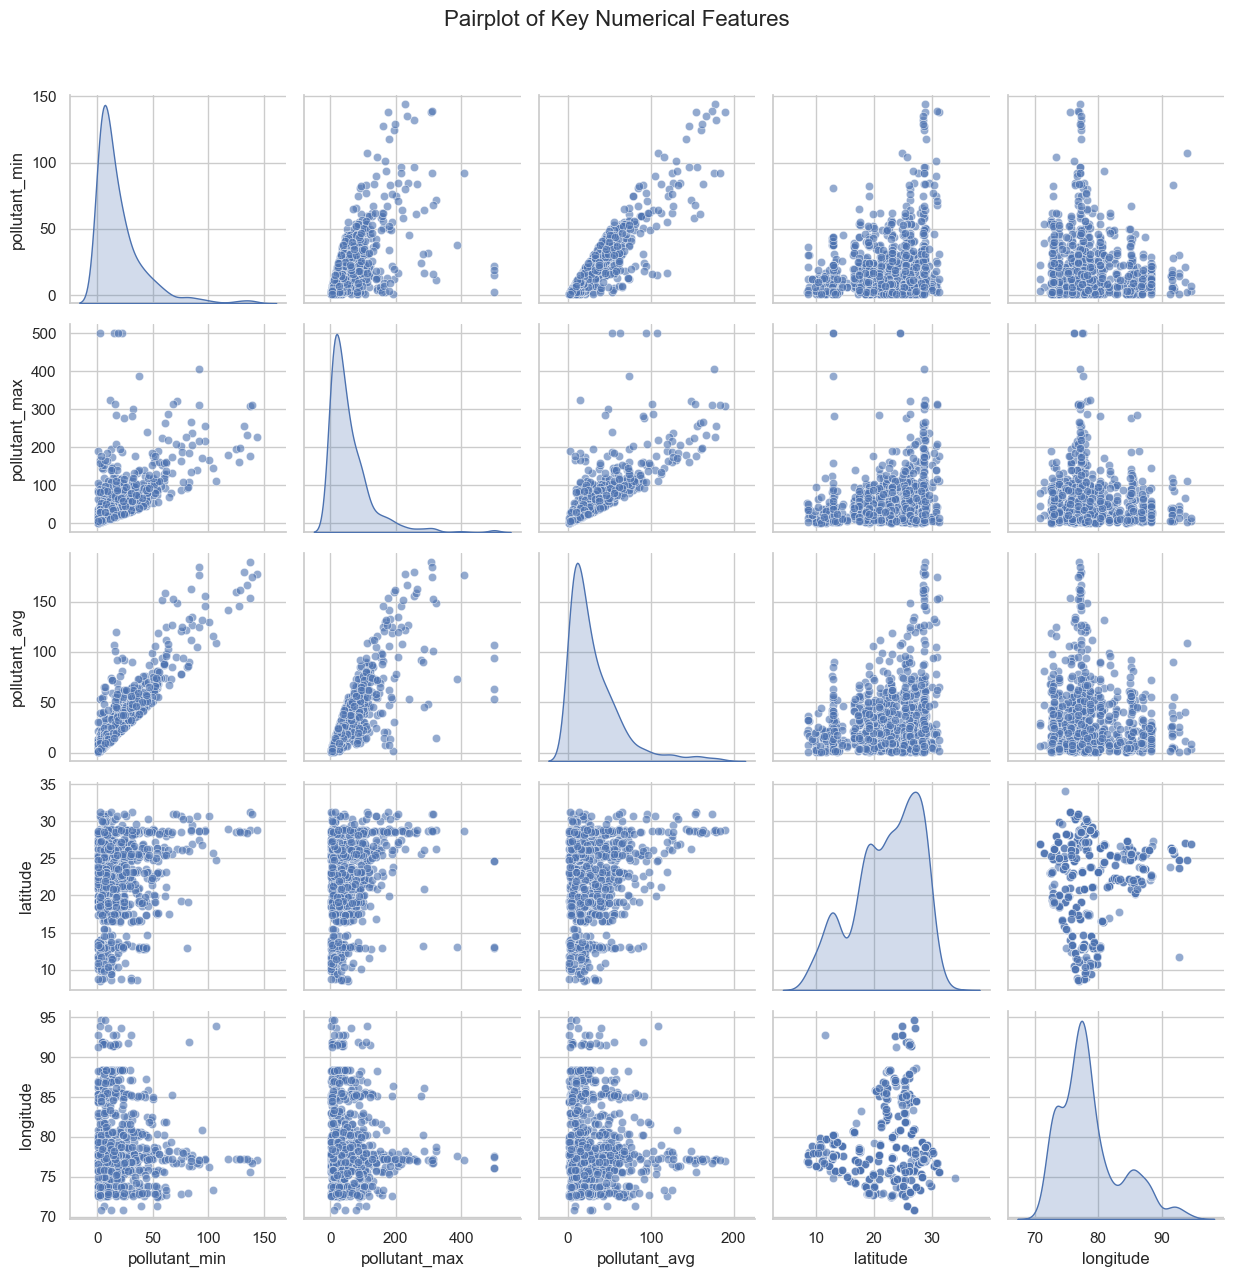

In [14]:
# Pairplot for numerical features
sample_df = df.sample(1000)  # Sample to make the plot manageable
sns.pairplot(sample_df[['pollutant_min', 'pollutant_max', 'pollutant_avg', 'latitude', 'longitude']], 
             diag_kind='kde', 
             plot_kws={'alpha': 0.6})
plt.suptitle('Pairplot of Key Numerical Features', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19336\2293785728.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='pollutant_avg', y='state', data=state_pollution, palette='mako')


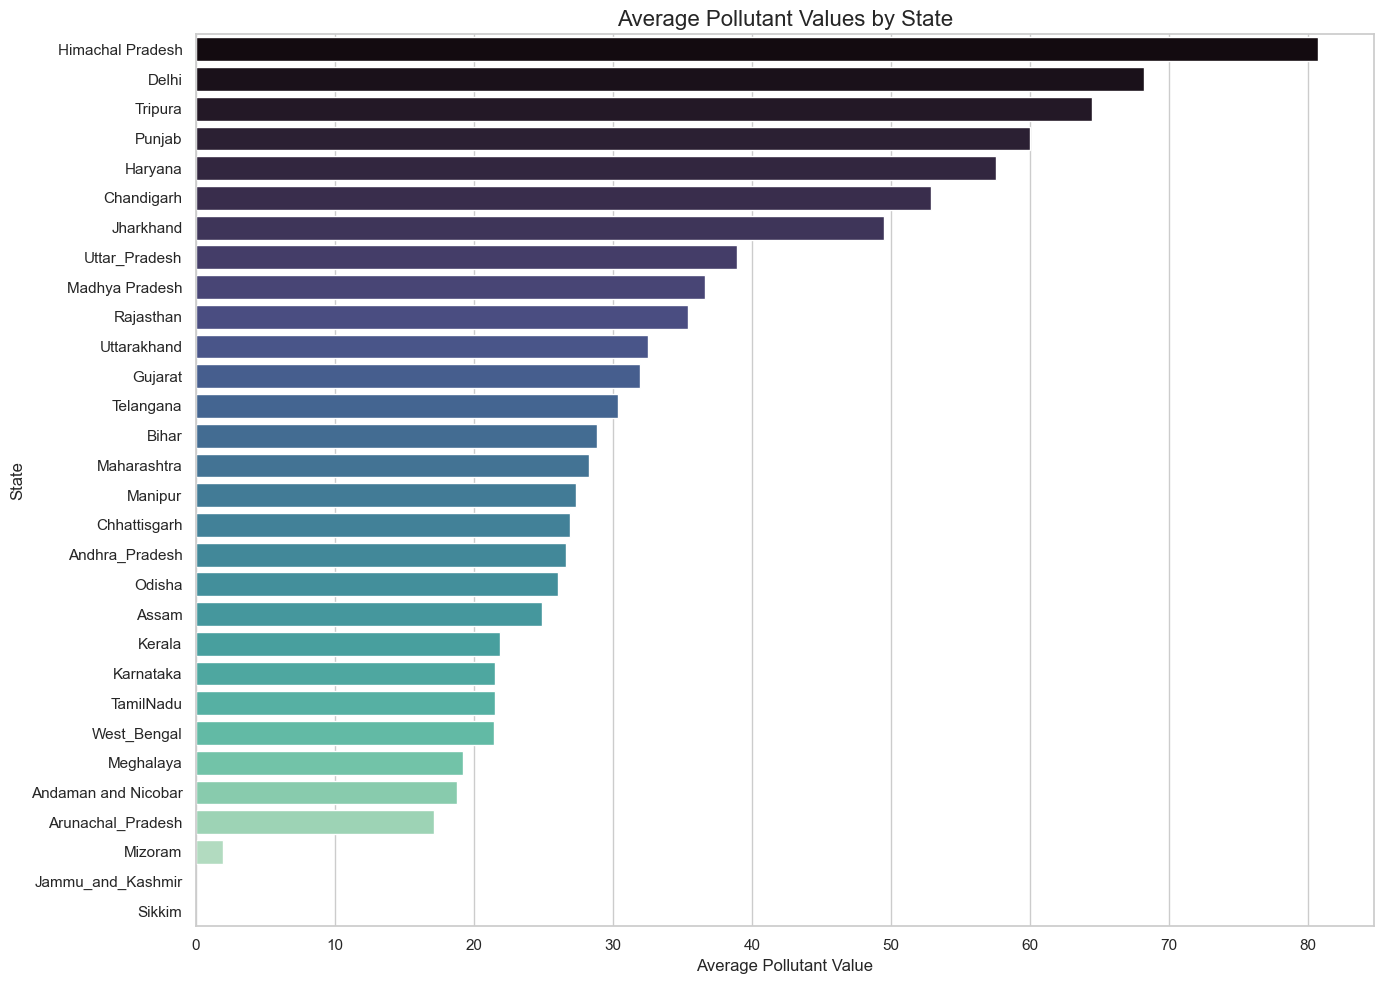

In [15]:
# Distribution of pollutant averages by state
state_pollution = df.groupby('state')['pollutant_avg'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(14, 10))
sns.barplot(x='pollutant_avg', y='state', data=state_pollution, palette='mako')
plt.title('Average Pollutant Values by State', fontsize=16)
plt.xlabel('Average Pollutant Value', fontsize=12)
plt.ylabel('State', fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19336\1034781391.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='pollutant_id', y='pollutant_avg', data=df, palette='plasma', inner='quartile')


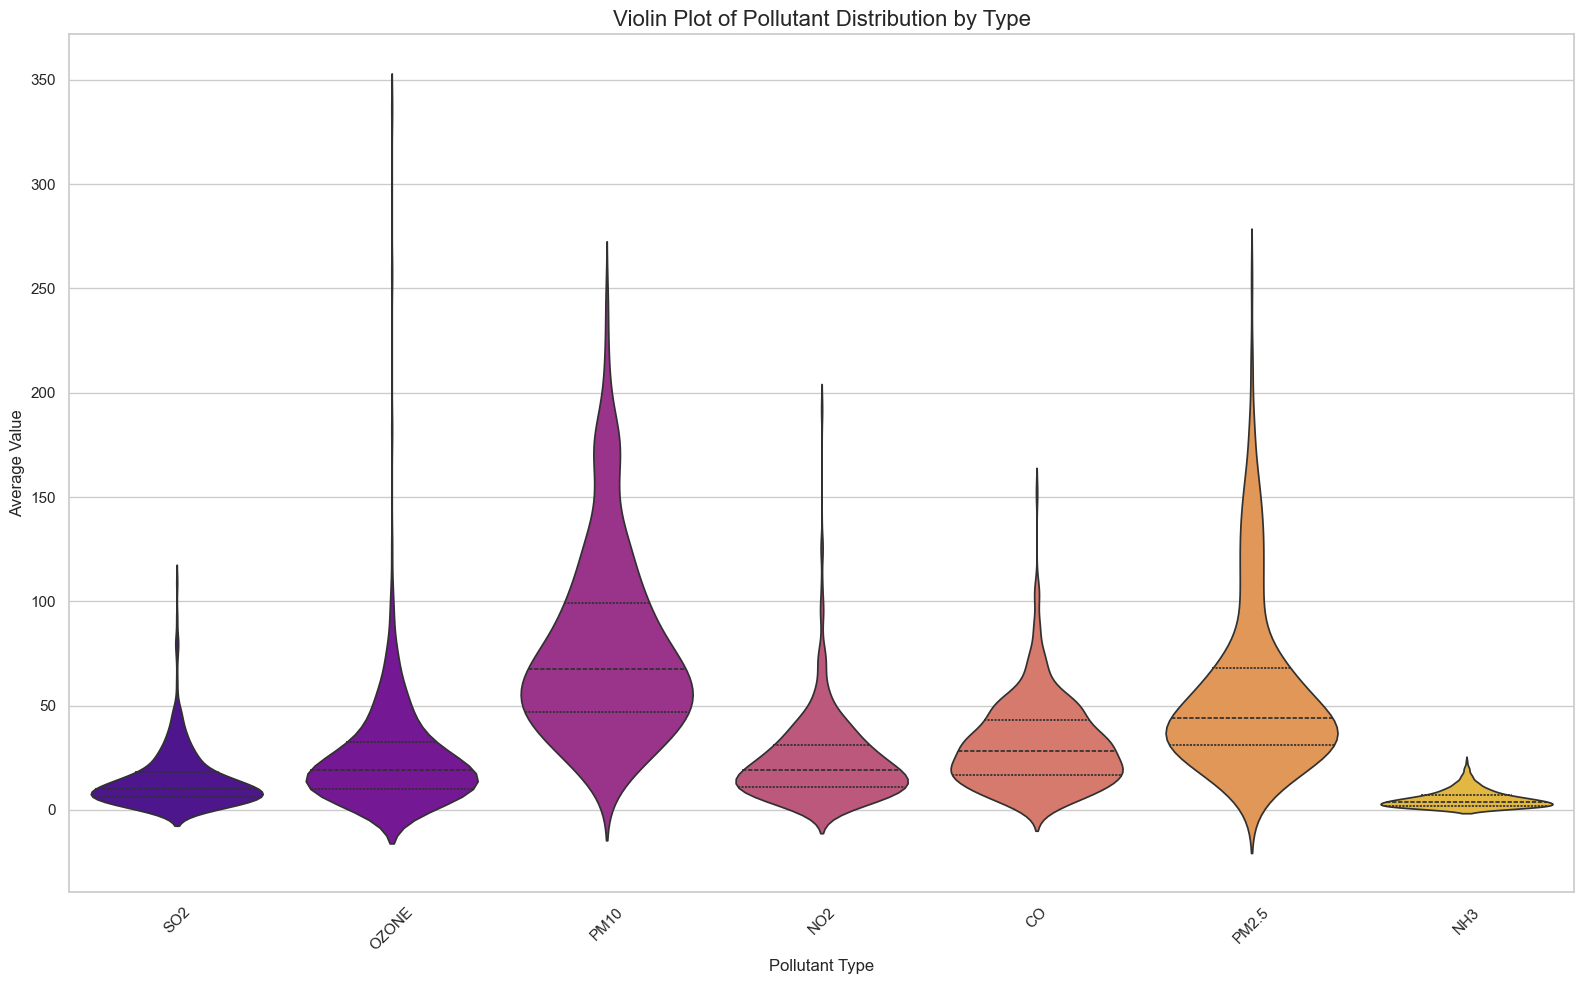

In [16]:
# Violin plot of pollutant distribution by pollutant type
plt.figure(figsize=(16, 10))
sns.violinplot(x='pollutant_id', y='pollutant_avg', data=df, palette='plasma', inner='quartile')
plt.title('Violin Plot of Pollutant Distribution by Type', fontsize=16)
plt.xlabel('Pollutant Type', fontsize=12)
plt.ylabel('Average Value', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Feature Engineering

In [17]:
# Create a new feature: range of pollutant values
df['pollutant_range'] = df['pollutant_max'] - df['pollutant_min']

# Create a new feature: time of day (morning, afternoon, evening, night)
def categorize_time(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['time_of_day'] = df['hour'].apply(categorize_time)

# Create a new feature: season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['season'] = df['month'].apply(get_season)

# Display the updated dataframe with new features
df.head()

,country,state,city,station,last_update,latitude,longitude,pollutant_id,pollutant_min,pollutant_max,pollutant_avg,year,month,day,hour,pollutant_range,time_of_day,season
0,India,Andhra_Pradesh,Vijayawada,"Rajiv Nagar, Vijayawada - APPCB",2025-05-19 10:00:00,16.554731,80.649110,SO2,20.0,23.0,21.0,2025,5,19,10,3.0,Morning,Spring
1,India,Andhra_Pradesh,Vijayawada,"Rajiv Nagar, Vijayawada - APPCB",2025-05-19 10:00:00,16.554731,80.649110,OZONE,17.0,35.0,22.0,2025,5,19,10,18.0,Morning,Spring
2,India,Andhra_Pradesh,Visakhapatnam,"GVM Corporation, Visakhapatnam - APPCB",2025-05-19 10:00:00,17.720000,83.300000,PM10,23.0,66.0,36.0,2025,5,19,10,43.0,Morning,Spring
3,India,Arunachal_Pradesh,Naharlagun,"Naharlagun, Naharlagun - APSPCB",2025-05-19 10:00:00,27.103358,93.679645,NO2,4.0,5.0,5.0,2025,5,19,10,1.0,Morning,Spring
4,India,Arunachal_Pradesh,Naharlagun,"Naharlagun, Naharlagun - APSPCB",2025-05-19 10:00:00,27.103358,93.679645,CO,10.0,19.0,12.0,2025,5,19,10,9.0,Morning,Spring


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19336\1342895191.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='time_of_day', y='pollutant_avg', data=df, palette='Set2', order=['Morning', 'Afternoon', 'Evening', 'Night'])


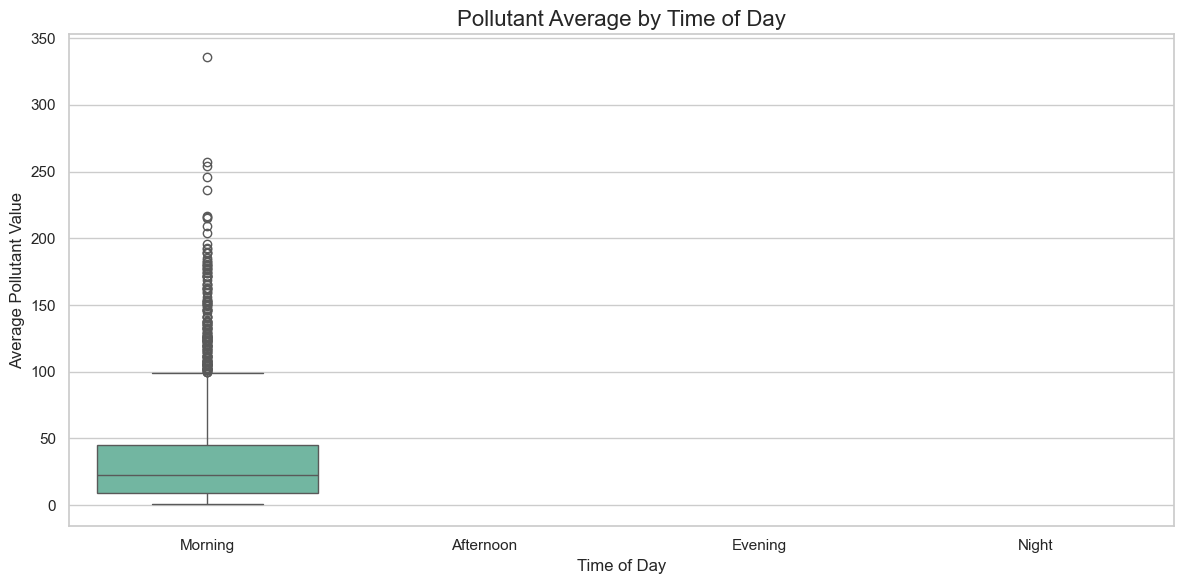

In [18]:
# Visualize the new features
plt.figure(figsize=(12, 6))
sns.boxplot(x='time_of_day', y='pollutant_avg', data=df, palette='Set2', order=['Morning', 'Afternoon', 'Evening', 'Night'])
plt.title('Pollutant Average by Time of Day', fontsize=16)
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Average Pollutant Value', fontsize=12)
plt.tight_layout()
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19336\3162453999.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='season', y='pollutant_avg', data=df, palette='Set3', order=['Winter', 'Spring', 'Summer', 'Fall'])


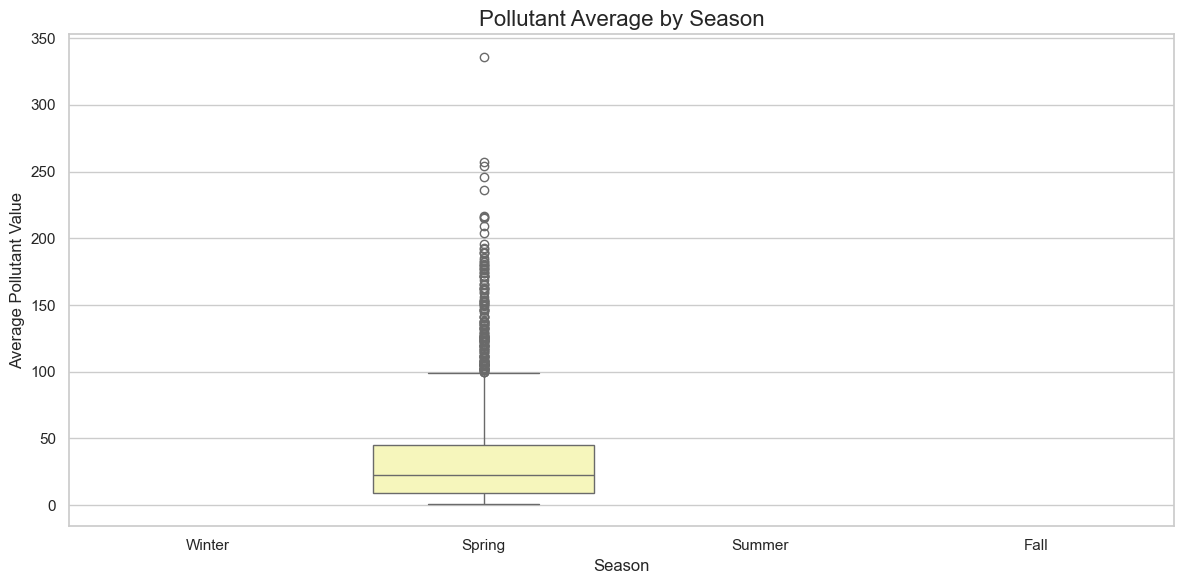

In [19]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='season', y='pollutant_avg', data=df, palette='Set3', order=['Winter', 'Spring', 'Summer', 'Fall'])
plt.title('Pollutant Average by Season', fontsize=16)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Average Pollutant Value', fontsize=12)
plt.tight_layout()
plt.show()

## 6. Prepare Data for Modeling

In [20]:
# Select features for modeling
# We'll predict pollutant_avg based on other features

# Drop unnecessary columns
model_df = df.drop(['last_update', 'station'], axis=1)

# Check for NaN values in the target variable
print(f"Number of NaN values in pollutant_avg: {model_df['pollutant_avg'].isna().sum()}")

# Remove rows with NaN values in the target variable
model_df = model_df.dropna(subset=['pollutant_avg'])
print(f"Shape after removing NaN values in target: {model_df.shape}")

# Define target variable and features
X = model_df.drop('pollutant_avg', axis=1)
y = model_df['pollutant_avg']
print(y)
# Identify categorical and numerical columns
categorical_cols = ['country', 'state', 'city', 'pollutant_id', 'time_of_day', 'season']
numerical_cols = ['latitude', 'longitude', 'pollutant_min', 'pollutant_max', 'pollutant_range', 'year', 'month', 'day', 'hour']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Number of NaN values in pollutant_avg: 299
Shape after removing NaN values in target: (2778, 16)
0       21.0
1       22.0
2       36.0
3        5.0
4       12.0
        ... 
3072    16.0
3073     4.0
3074    20.0
3075     5.0
3076    36.0
Name: pollutant_avg, Length: 2778, dtype: float64
Training set shape: (2222, 15)
Testing set shape: (556, 15)


In [21]:
# Create preprocessing pipelines for both numerical and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create and evaluate different models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

## 7. Model Training and Evaluation

In [22]:
# Function to evaluate models
def evaluate_model(model_name, model, X_train, X_test, y_train, y_test):
    # Check for any NaN values in the input data
    print(f"\nChecking for NaN values before model training for {model_name}:")
    print(f"X_train NaNs: {X_train.isna().sum().sum()}")
    print(f"X_test NaNs: {X_test.isna().sum().sum()}")
    print(f"y_train NaNs: {y_train.isna().sum()}")
    print(f"y_test NaNs: {y_test.isna().sum()}")
    
    # Create a pipeline with preprocessing and the model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    
    # Train the model
    try:
        pipeline.fit(X_train, y_train)
        
        # Make predictions
        y_pred = pipeline.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Print metrics
        print(f"Model: {model_name}")
        print(f"Mean Squared Error: {mse:.4f}")
        print(f"Root Mean Squared Error: {rmse:.4f}")
        print(f"Mean Absolute Error: {mae:.4f}")
        print(f"R² Score: {r2:.4f}")
        print("-" * 50)
        
        return pipeline, y_pred, r2
    except Exception as e:
        print(f"Error training {model_name}: {e}")
        return None, None, -999  # Return placeholder values to continue execution
    print("-" * 50)
    
    return pipeline, y_pred, r2

In [23]:
# Evaluate all models
results = {}
predictions = {}

for name, model in models.items():
    pipeline, y_pred, r2 = evaluate_model(name, model, X_train, X_test, y_train, y_test)
    if pipeline is not None:  # Only add successful models to results
        results[name] = r2
        predictions[name] = y_pred


Checking for NaN values before model training for Linear Regression:
X_train NaNs: 0
X_test NaNs: 0
y_train NaNs: 0
y_test NaNs: 0
Model: Linear Regression
Mean Squared Error: 102.6437
Root Mean Squared Error: 10.1313
Mean Absolute Error: 6.0834
R² Score: 0.9219
--------------------------------------------------

Checking for NaN values before model training for Ridge Regression:
X_train NaNs: 0
X_test NaNs: 0
y_train NaNs: 0
y_test NaNs: 0
Model: Ridge Regression
Mean Squared Error: 94.5739
Root Mean Squared Error: 9.7249
Mean Absolute Error: 5.8832
R² Score: 0.9280
--------------------------------------------------

Checking for NaN values before model training for Lasso Regression:
X_train NaNs: 0
X_test NaNs: 0
y_train NaNs: 0
y_test NaNs: 0
Model: Lasso Regression
Mean Squared Error: 92.4763
Root Mean Squared Error: 9.6165
Mean Absolute Error: 5.2643
R² Score: 0.9296
--------------------------------------------------

Checking for NaN values before model training for Random Fores

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19336\3583492381.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')


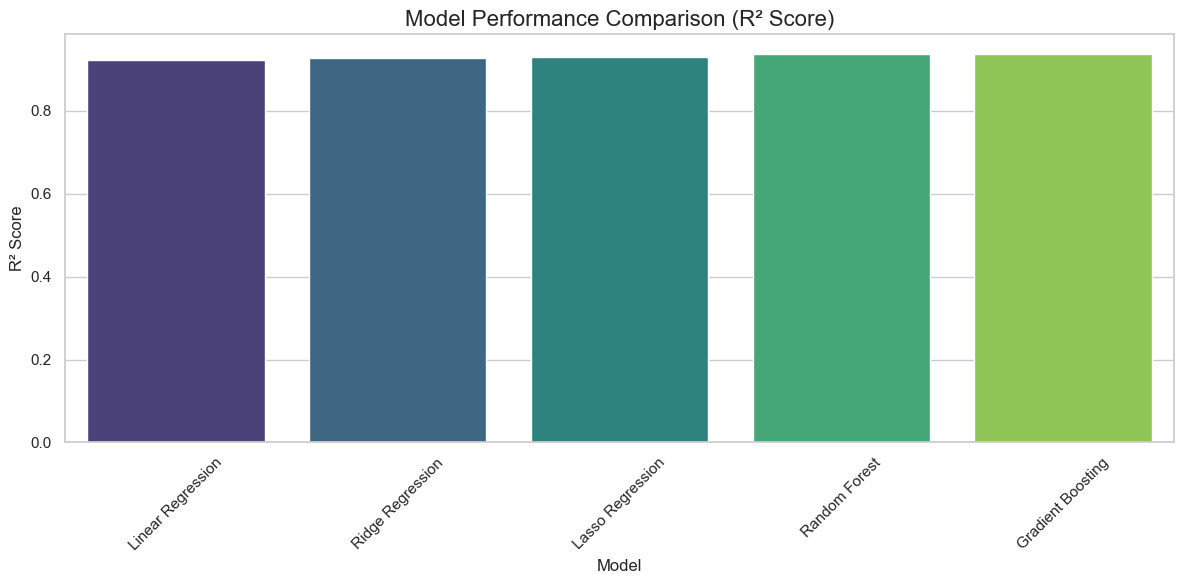

In [24]:
# Visualize model performance comparison
if results:  # Only create visualization if there are successful models
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')
    plt.title('Model Performance Comparison (R² Score)', fontsize=16)
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('R² Score', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No successful models to visualize.")

In [25]:
# Find the best model
if results:
    best_model_name = max(results, key=results.get)
    print(f"The best performing model is: {best_model_name} with R² Score of {results[best_model_name]:.4f}")
else:
    print("No successful models to determine the best one.")

The best performing model is: Random Forest with R² Score of 0.9374


## 8. Visualize Predictions vs Actual Values

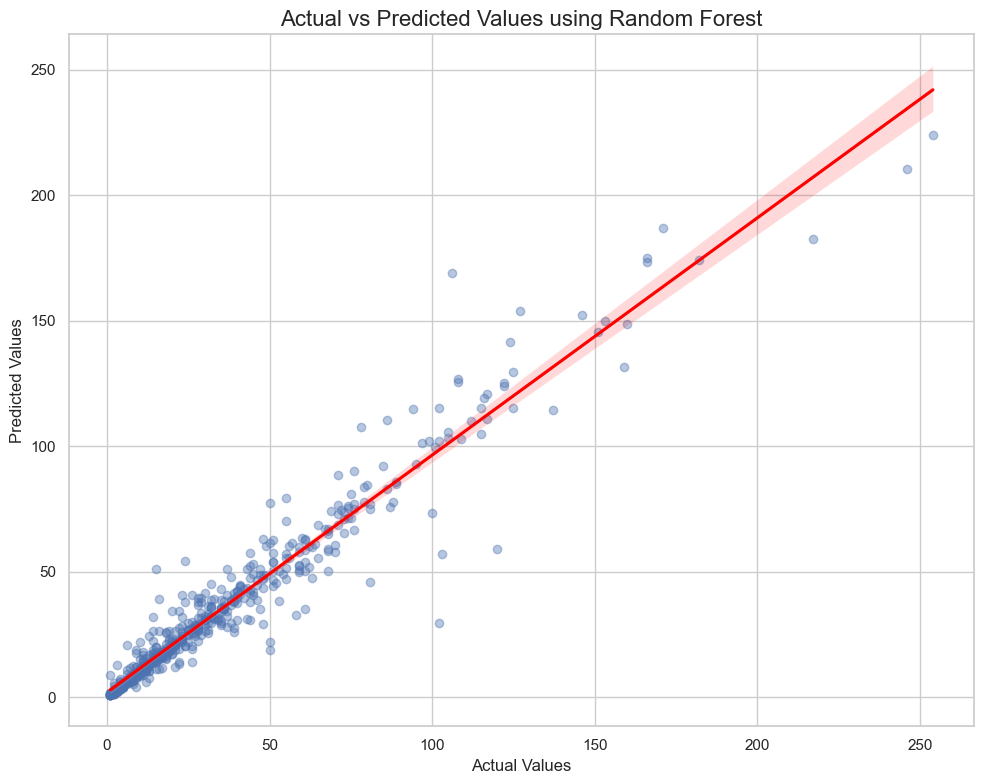

In [26]:
# Create a dataframe with actual and predicted values for the best model
if results and best_model_name in predictions:
    best_predictions = predictions[best_model_name]
    prediction_df = pd.DataFrame({'Actual': y_test, 'Predicted': best_predictions})
    
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 8))
    sns.regplot(x='Actual', y='Predicted', data=prediction_df, scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
    plt.title(f'Actual vs Predicted Values using {best_model_name}', fontsize=16)
    plt.xlabel('Actual Values', fontsize=12)
    plt.ylabel('Predicted Values', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("No successful models to visualize predictions.")

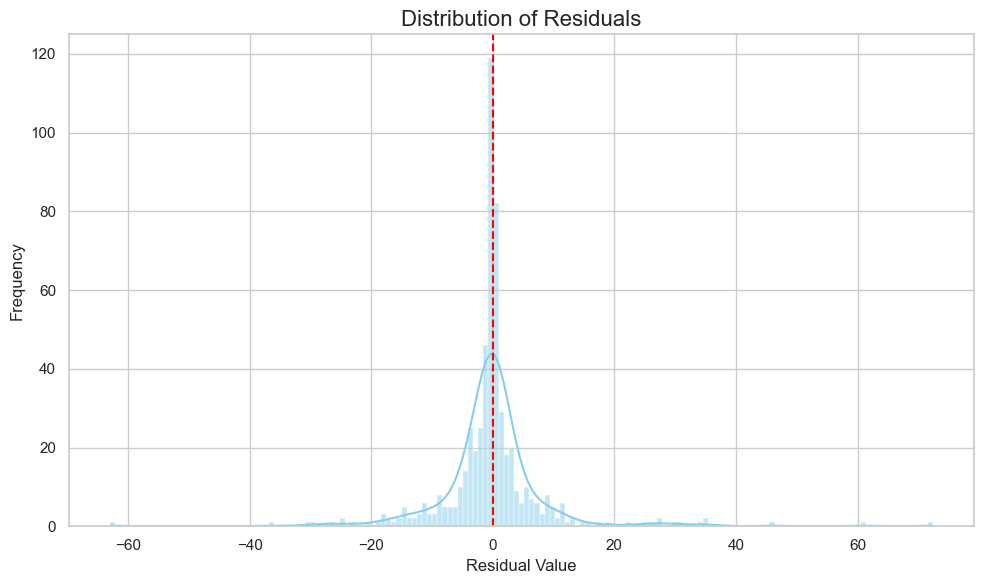

In [27]:
# Plot residuals
if results and best_model_name in predictions:
    prediction_df['Residuals'] = prediction_df['Actual'] - prediction_df['Predicted']
    
    plt.figure(figsize=(10, 6))
    sns.histplot(prediction_df['Residuals'], kde=True, color='skyblue')
    plt.axvline(x=0, color='red', linestyle='--')
    plt.title('Distribution of Residuals', fontsize=16)
    plt.xlabel('Residual Value', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.tight_layout()
    plt.show()

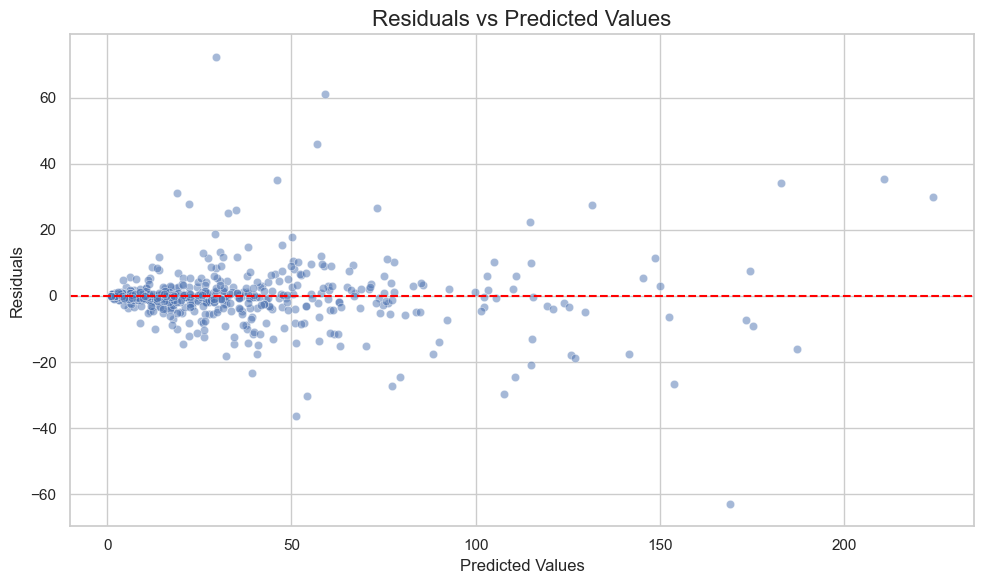

In [28]:
# Residual plot
if results and best_model_name in predictions:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Predicted', y='Residuals', data=prediction_df, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title('Residuals vs Predicted Values', fontsize=16)
    plt.xlabel('Predicted Values', fontsize=12)
    plt.ylabel('Residuals', fontsize=12)
    plt.tight_layout()
    plt.show()

## 9. Feature Importance Analysis

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_19336\3405953142.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


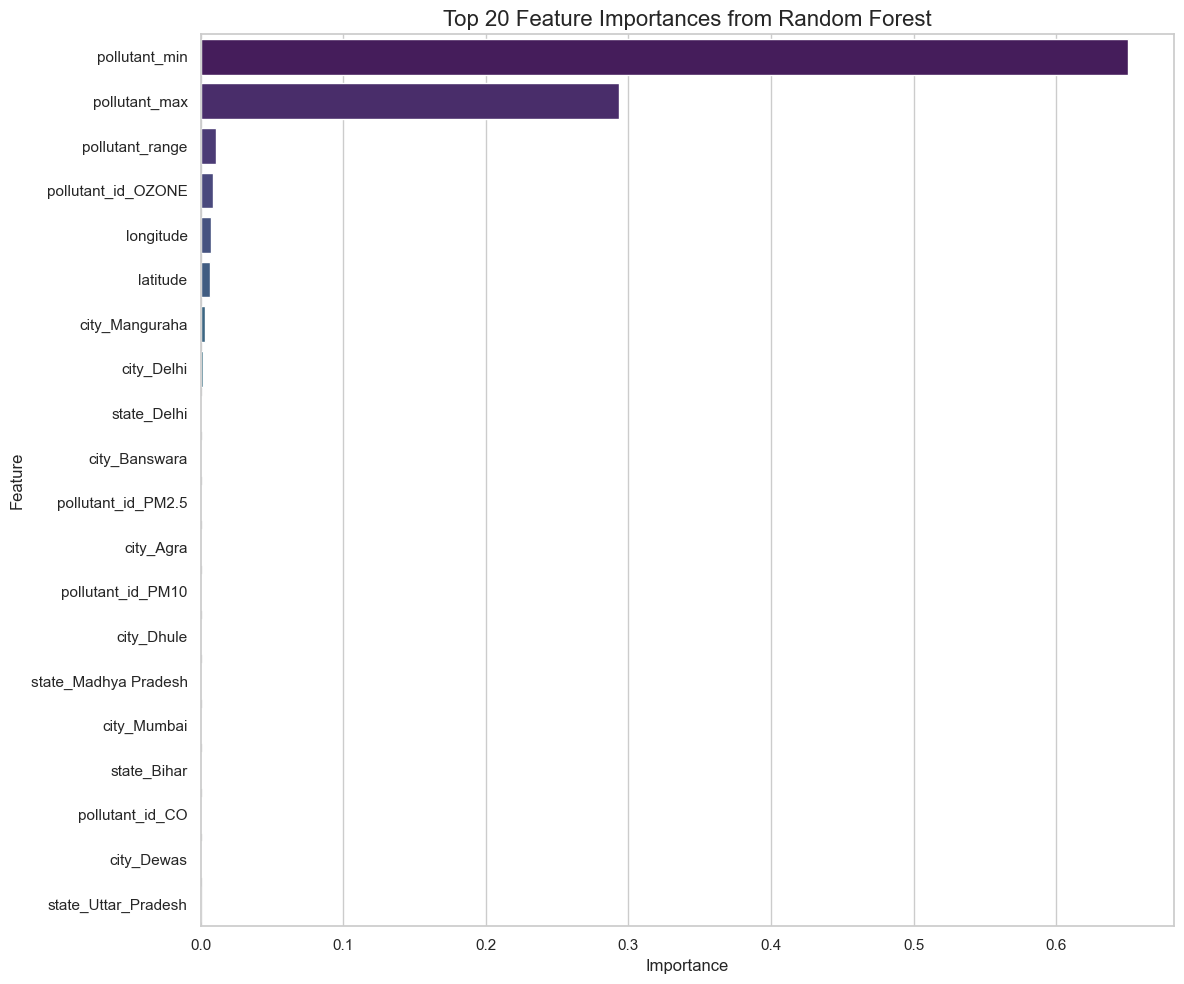

In [29]:
# If the best model is tree-based, we can extract feature importance
if results and best_model_name in ['Random Forest', 'Gradient Boosting']:
    # Get the best model pipeline
    best_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('model', models[best_model_name])])
    best_pipeline.fit(X_train, y_train)
    
    # Get feature names after preprocessing
    feature_names = []
    for name, transformer, cols in preprocessor.transformers_:
        if name == 'num':
            feature_names.extend(cols)
        elif name == 'cat':
            feature_names.extend(transformer.named_steps['onehot'].get_feature_names_out(cols))
    
    # Get feature importances
    importances = best_pipeline.named_steps['model'].feature_importances_
    
    # Create a dataframe for visualization
    feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance = feature_importance.sort_values('Importance', ascending=False).head(20)
    
    # Plot feature importances
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
    plt.title(f'Top 20 Feature Importances from {best_model_name}', fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

## 10. Conclusion and Next Steps

### Summary of Findings

In this notebook, we built a machine learning model to predict Air Quality Index using the AQI.csv dataset. We performed the following steps:

1. Loaded and explored the dataset
2. Visualized the data using seaborn to understand patterns and relationships
3. Performed feature engineering to create new meaningful features
4. Used KNN imputation to handle missing values, which provided more accurate estimates than simple imputation methods
5. Prepared the data for modeling by preprocessing both numerical and categorical features
6. Trained and evaluated multiple regression models
7. Analyzed the performance of each model and identified the best one
8. Visualized the predictions and residuals
9. Examined feature importance for tree-based models

### Next Steps

To further improve the model, we could:

1. Perform hyperparameter tuning using GridSearchCV or RandomizedSearchCV
2. Try more advanced models like XGBoost or LightGBM
3. Create more domain-specific features
4. Experiment with different KNN imputation parameters (e.g., different values of k)
5. Try more advanced imputation techniques like MICE (Multiple Imputation by Chained Equations)
6. Handle outliers more carefully
7. Explore time series aspects of the data more thoroughly
8. Consider geographical clustering of pollution data
9. Incorporate external data sources like weather conditions or traffic patterns